<a href="https://colab.research.google.com/github/LANZhengyang/Bayesian-Learning-via-SGLD/blob/main/2D_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.distributions.normal import Normal
import torch
import numpy as np
import seaborn as sns
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Introduction
This notebook will show the implementation of Stochastic Gradient Langevin Dynamics on estimatation of mean of 1D normal distribution.

## Sample train data and show ture distribution

Text(-5.950000000000003, 0.5, 'Probability')

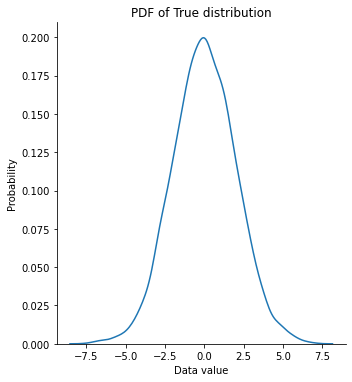

In [2]:
nd = Normal(0,2) # normal distribution with meam=0 and var=2
N=5000  # Sample 5000 data point to approach to true distribution.

# sample theta 
theta = nd.sample(sample_shape=torch.Size([N]))

#sample X
data = []
for i in range(N):
    m=Normal(theta[i], 2)
    data.append(m.sample().numpy())

data  = nd.sample(sample_shape=torch.Size(torch.tensor([N])))

# plot distribution
ax = sns.displot(data.numpy(),kind="kde")
plt.title('PDF of True distribution')
plt.xlabel('Data value')
plt.ylabel('Probability')

- It has a complete true distribution. But we can use it to evaluate if the sample is overfitting on this.

## Start Stochastic Gradient Langevin Dynamics

In [3]:
para = torch.randn((1), requires_grad=True) # generate parameter randomly

n = batch_size = 100 # set batch size 

data_hat =  [] # sample list

a=0.001
b=1
gamma=0.55

injected_noise_v = [] # list of variance of injected noise 
Vs = []  # empirical covariance list

for t in range(1000):

    # select data from all data
    sample_index = torch.randperm(N)[:batch_size]
    batch = torch.tensor(data)[sample_index]
    
    # update learning rate/ step size when injected noise is smaller than SG noise
    if t<300:
        learning_rate = learning_rate = a *(b+t)**(-gamma)
    
    if t % 200 == 0:
        print("Iteration:",t,"learning_rate",learning_rate,"para",para)
    
    p= Normal(0, 2) # proir
    pos = Normal(para, 2) # posterior
    (p.log_prob(para)+(N/batch_size)*sum(pos.log_prob(batch))).backward()
    
    # updata parameter
    with torch.no_grad():
          
        para += (learning_rate/2) * (para.grad) + Normal(0, learning_rate).sample()

        # Manually zero the gradients after updating weights
        para.grad = None


    # save Vs and learning rate    
    st = []
    for i in range(len(batch)):
        ((1/N)*p.log_prob(para)+(pos.log_prob(batch[i]))).backward()
        with torch.no_grad():
        
            st.append((para.grad.numpy()))
            para.grad = None
        
    Vs.append(np.var(np.array(st)))
    
    injected_noise_v.append(learning_rate)


    # start sample when the injected noise is bigger than SG noise    
    if t>300:
        m_hat = Normal(para, 2)
        data_hat.append(m_hat.sample().numpy())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 0 learning_rate 0.001 para tensor([0.0117], requires_grad=True)
Iteration: 200 learning_rate 5.410559388820043e-05 para tensor([-0.0202], requires_grad=True)
Iteration: 400 learning_rate 4.3409352701374194e-05 para tensor([-0.0029], requires_grad=True)
Iteration: 600 learning_rate 4.3409352701374194e-05 para tensor([0.0040], requires_grad=True)
Iteration: 800 learning_rate 4.3409352701374194e-05 para tensor([0.0044], requires_grad=True)


## Compare Variance of SG noise and injected noise
When the Langevin dynamics phase dominate, we fix the learning rate to avoid slow down. (pages 3)

Text(0, 0.5, 'Variance of noise')

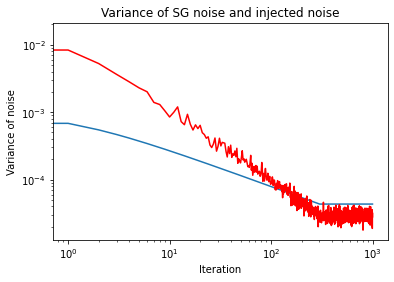

In [4]:
plt.plot(range(len(injected_noise_v)),(injected_noise_v))
plt.xscale("log")
plt.yscale("log")


plt.plot(np.array(N**2/n)*Vs*(np.array(injected_noise_v)/2)**2,c='r')


plt.title('Variance of SG noise and injected noise')
plt.xlabel('Iteration')
plt.ylabel('Variance of noise')

## Show the Evolution of distribution of sample

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

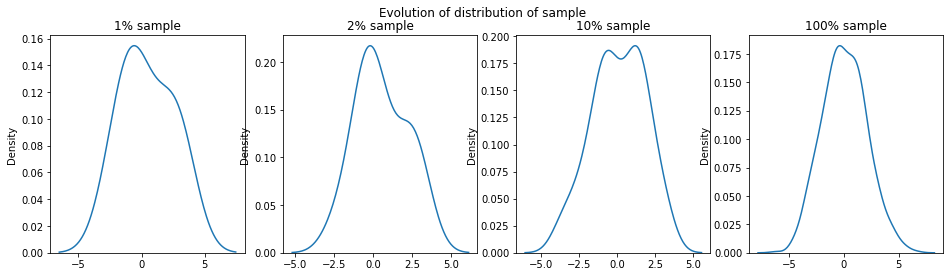

In [5]:
fig, axes = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches( 16, 4)
ax1=sns.distplot(np.array(data_hat)[::100,::100], hist=False, ax=axes.flat[0])
ax1.set_title('1% sample')
ax2=sns.distplot(np.array(data_hat)[::50,::50], hist=False, ax=axes.flat[1])
ax2.set_title('2% sample')
ax3=sns.distplot(np.array(data_hat)[::10,::10], hist=False, ax=axes.flat[2])
ax3.set_title('10% sample')
ax4=sns.distplot(np.array(data_hat)[::1,::1], hist=False, ax=axes.flat[3])
ax4.set_title('100% sample')

# axes.set_title('Evolution of distribution of sample')
fig.suptitle('Evolution of distribution of sample')
plt.show()

- We can see that the sample is follow the true distribution and not overfitting on the train data.